In [1]:
import gym

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import json
import math
import random
import random
import numpy as np
import scipy as sp
import scipy.stats as st
import scipy.integrate as integrate
from scipy.stats import multivariate_normal
from sklearn import linear_model
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
import statsmodels.api as sm
from matplotlib.colors import LogNorm
import pickle

from joblib import Parallel, delayed
import multiprocessing
from collections import namedtuple
from itertools import count

import cProfile
from datetime import datetime

import time
import tensorflow as tf

sns.set_style("whitegrid")
sns.set_palette("colorblind")
palette = sns.color_palette()
figsize = (15,8)
legend_fontsize = 16

from matplotlib import rc

/home/kiramipt/PycharmProjects/rl-homework/venv/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
from IPython import display

In [3]:
class TicTacToe(gym.Env):
    def __init__(self, n_rows, n_cols, n_win):
        self.n_rows = n_rows
        self.n_cols = n_cols
        self.n_win = n_win

        self.board = np.zeros((self.n_rows, self.n_cols), dtype=int)
        self.gameOver = False
        self.boardHash = None
        
        # ход первого игрока
        self.curTurn = 1
        self.emptySpaces = None
        
        self.reset()

    def getEmptySpaces(self):
        if self.emptySpaces is None:
            res = np.where(self.board == 0)
            self.emptySpaces = np.array([ (i, j) for i,j in zip(res[0], res[1]) ])
        return self.emptySpaces

    def makeMove(self, player, i, j):
        self.board[i, j] = player
        self.emptySpaces = None
        self.boardHash = None

    def getHash(self):
        if self.boardHash is None:
            self.boardHash = ''.join(['%s' % (x+1) for x in self.board.reshape(self.n_rows * self.n_cols)])
        return self.boardHash

    def isTerminal(self):
        # проверим, не закончилась ли игра
        cur_marks, cur_p = np.where(self.board == self.curTurn), self.curTurn
        for i,j in zip(cur_marks[0], cur_marks[1]):
            win = False
            if i <= self.n_rows - self.n_win:
                if np.all(self.board[i:i+self.n_win, j] == cur_p):
                    win = True
            if not win:
                if j <= self.n_cols - self.n_win:
                    if np.all(self.board[i,j:j+self.n_win] == cur_p):
                        win = True
            if not win:
                if i <= self.n_rows - self.n_win and j <= self.n_cols - self.n_win:
                    if np.all(np.array([ self.board[i+k,j+k] == cur_p for k in range(self.n_win) ])):
                        win = True
            if not win:
                if i <= self.n_rows - self.n_win and j >= self.n_win-1:
                    if np.all(np.array([ self.board[i+k,j-k] == cur_p for k in range(self.n_win) ])):
                        win = True
            if win:
                self.gameOver = True
                return self.curTurn

        if len(self.getEmptySpaces()) == 0:
            self.gameOver = True
            return 0

        self.gameOver = False
        return None

    def printBoard(self):
        for i in range(0, self.n_rows):
            print('----'*(self.n_cols)+'-')
            out = '| '
            for j in range(0, self.n_cols):
                if self.board[i, j] == 1:
                    token = 'x'
                if self.board[i, j] == -1:
                    token = 'o'
                if self.board[i, j] == 0:
                    token = ' '
                out += token + ' | '
            print(out)
        print('----'*(self.n_cols)+'-')

    def getState(self):
        return (self.getHash(), self.getEmptySpaces(), self.curTurn)

    def action_from_int(self, action_int):
        return ( int(action_int / self.n_cols), int(action_int % self.n_cols))

    def int_from_action(self, action):
        return action[0] * self.n_cols + action[1]
    
    def step(self, action):
        if self.board[action[0], action[1]] != 0:
            return self.getState(), -10, True, {}
        self.makeMove(self.curTurn, action[0], action[1])
        reward = self.isTerminal()
        self.curTurn = -self.curTurn
        return self.getState(), 0 if reward is None else reward, reward is not None, {}

    def reset(self):
        self.board = np.zeros((self.n_rows, self.n_cols), dtype=int)
        self.boardHash = None
        self.gameOver = False
        self.emptySpaces = None
        self.curTurn = 1
        
    def is_legal(self, action):
        return list(action) in self.getEmptySpaces().tolist()
    
    def get_state(self):
        return self.board.reshape(-1)

In [4]:
env = TicTacToe(n_rows=3, n_cols=3, n_win=3)

done = False
env.reset()

while not done:
    s, actions = env.getHash(), env.getEmptySpaces()
    
    if env.curTurn == 1:
        a = np.random.randint(len(actions))    
    else:
        a = np.random.randint(len(actions))
        
    observation, reward, done, info = env.step(actions[a])
    env.printBoard()

    if reward == 1:
        print("Крестики выиграли!")
    if reward == -1:
        print("Нолики выиграли!")
    
    time.sleep(0.5)
    display.clear_output(wait=True)

-------------
| x | x | x | 
-------------
| x | o | o | 
-------------
|   |   | o | 
-------------
Крестики выиграли!


## Часть первая: крестики-нолики при помощи Q-обучения

### 1. Часть первая: крестики-нолики при помощи Q-обучения

In [5]:
class RandomPlayer:
    """
    This player can play a game of Tic Tac Toe by randomly choosing a free spot on the board.
    It does not learn or get better.
    """

    def move(self, board):
        actions = board.getEmptySpaces()
        player_action = actions[np.random.randint(len(actions))]
        observation, reward, done, info = board.step(player_action)
        return reward, done
    
    def final_result(self, final_value):
        pass
    
    def new_game(self):
        pass

In [6]:
class TQPlayer:
    """
    A Tic Tac Toe player, implementing Tabular Q Learning
    """

    def __init__(self, alpha=0.9, gamma=0.95, q_init=0.6, board_size=9):

        self.side = None
        self.q = {}
        self.move_history = []
        self.learning_rate = alpha
        self.value_discount = gamma
        self.q_init_val = q_init
        self.board_size = board_size

    def get_q(self, board_hash):

        if board_hash in self.q:
            qvals = self.q[board_hash]
        else:
            qvals = np.full(self.board_size, self.q_init_val)
            self.q[board_hash] = qvals

        return qvals

    def get_move(self, board) -> int:

        board_hash = board.getHash() 
        qvals = self.get_q(board_hash)
        while True:
            m = np.argmax(qvals)
            if board.is_legal(board.action_from_int(m)):
                return m
            else:
                qvals[m] = -1.0

    def move(self, board):
        
        player_action = self.get_move(board)
        self.move_history.append((board.getHash(), player_action))
        
        observation, reward, done, info = board.step(board.action_from_int(player_action))  
        return reward, done

    def final_result(self, final_value):

        self.move_history.reverse()
        next_max = -1.0  

        for h in self.move_history:
            qvals = self.get_q(h[0])
            if next_max < 0:
                qvals[h[1]] = final_value
            else:
                qvals[h[1]] = qvals[h[1]] * (
                            1.0 - self.learning_rate) + self.learning_rate * self.value_discount * next_max

            next_max = max(qvals)

    def new_game(self):
        self.move_history = []

In [7]:
def play_game(board, player_1, player_2, verbose=False):
    
    player_1.new_game()
    player_2.new_game()

    board.reset()    
    done = False

    while not done:

        if board.curTurn == 1:
            reward, done = player_1.move(board)
        else:
            reward, done = player_2.move(board)

        if verbose:
            board.printBoard()
            time.sleep(0.5)
            if not done:
                display.clear_output(wait=True)

    if reward == 1:
        reward_str = "CROSS WIN"
        player_1.final_result(1)
        player_2.final_result(0)

    elif reward == -1:
        reward_str = "NAUGHT WIN"
        player_1.final_result(0)
        player_2.final_result(1)
    else:
        reward_str = 'DRAW'
        player_1.final_result(0.5)
        player_2.final_result(0.5)

    if verbose:
        print(reward_str)
        
    return reward

In [8]:
def battle(board, player_1, player_2, num_games=100, verbose=False):
      
    draw_count = 0
    cross_count = 0
    naught_count = 0
    
    for _ in range(num_games):
        reward = play_game(board, player_1, player_2)
        if reward == 1:
            cross_count += 1
        elif reward == -1:
            naught_count += 1
        else:
            draw_count += 1

    if verbose:
        print("After {} game we have draws: {}, Player 1 wins: {}, and Player 2 wins: {}.".format(num_games, draw_count,
                                                                                                  cross_count,
                                                                                                  naught_count))

        print("Which gives percentages of draws: {:.2%}, Player 1 wins: {:.2%}, and Player 2 wins:  {:.2%}".format(
            draw_count / num_games, cross_count / num_games, naught_count / num_games))

    return cross_count, naught_count, draw_count

In [9]:
def eval_players(board, player_1, player_2, num_battles, games_per_battle=100):
    player_1_wins = []
    player_2_wins = []
    draws = []
    count = []    

    for i in range(num_battles):
        
        player_1_win, player_2_win, draw = battle(board, player_1, player_2, games_per_battle)
        
        player_1_wins.append(player_1_win * 100.0 / games_per_battle)
        player_2_wins.append(player_2_win * 100.0 / games_per_battle)
        draws.append(draw * 100.0 / games_per_battle)
        
        count.append(i * games_per_battle)
        
    
    plt.figure(figsize=(10,5))

    plt.ylabel('Game outcomes in %')
    plt.xlabel('Game number')

    plt.plot(count, draws, 'r-', label='Draw')
    plt.plot(count, player_1_wins, 'g-', label='Player 1 wins')
    plt.plot(count, player_2_wins, 'b-', label='Player 2 wins')
    
    plt.legend(loc='best', shadow=True, fancybox=True, framealpha =0.7)

In [10]:
%%time

board = TicTacToe(n_rows=3, n_cols=3, n_win=3)

player_1 = RandomPlayer() 
player_2 = RandomPlayer() 

reward = play_game(board, player_1, player_2, verbose=True)

-------------
| x | o | x | 
-------------
| o | o | x | 
-------------
| x | x | o | 
-------------
DRAW
CPU times: user 21.2 ms, sys: 5.75 ms, total: 27 ms
Wall time: 4.52 s


In [232]:
%%time

board = TicTacToe(n_rows=3, n_cols=3, n_win=3)

player_1 = RandomPlayer()
player_2 = RandomPlayer()

_ = battle(board, player_1, player_2, num_games=10000, verbose=True);

After 10000 game we have draws: 1304, Player 1 wins: 5832, and Player 2 wins: 2864.
Which gives percentages of draws: 13.04%, Player 1 wins: 58.32%, and Player 2 wins:  28.64%
CPU times: user 4.37 s, sys: 0 ns, total: 4.37 s
Wall time: 4.37 s


CPU times: user 4.38 s, sys: 0 ns, total: 4.38 s
Wall time: 4.38 s


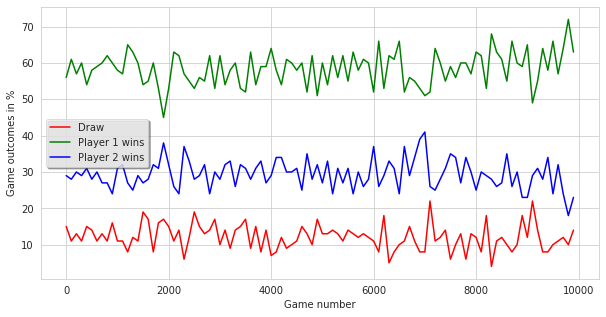

In [234]:
%%time

player_1 = RandomPlayer() 
player_2 = RandomPlayer()

board = TicTacToe(n_rows=3, n_cols=3, n_win=3)

eval_players(board, player_1, player_2, num_battles=100)

In [236]:
%%time

board = TicTacToe(n_rows=3, n_cols=3, n_win=3)

player_1 = TQPlayer() 
player_2 = RandomPlayer() 

reward = play_game(board, player_1, player_2, verbose=True)

-------------
| x | x | x | 
-------------
| o |   |   | 
-------------
|   |   | o | 
-------------
CROSS WIN
CPU times: user 15.7 ms, sys: 0 ns, total: 15.7 ms
Wall time: 2.51 s


In [237]:
%%time

board = TicTacToe(n_rows=3, n_cols=3, n_win=3)

player_1 = TQPlayer()
player_2 = RandomPlayer()

_ = battle(board, player_1, player_2, num_games=10000, verbose=True);

After 10000 game we have draws: 312, Player 1 wins: 9178, and Player 2 wins: 510.
Which gives percentages of draws: 3.12%, Player 1 wins: 91.78%, and Player 2 wins:  5.10%
CPU times: user 4.14 s, sys: 0 ns, total: 4.14 s
Wall time: 4.14 s


CPU times: user 21.7 s, sys: 217 ms, total: 22 s
Wall time: 21.8 s


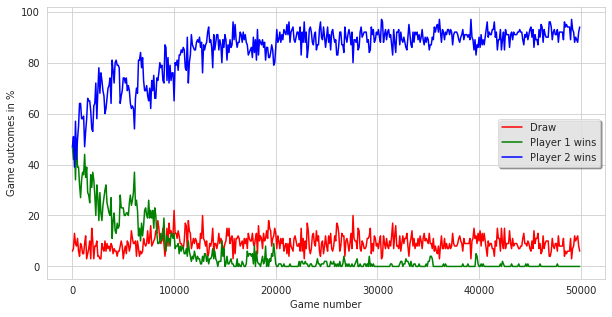

In [238]:
%%time

board = TicTacToe(n_rows=3, n_cols=3, n_win=3)

player_1 = RandomPlayer()
player_2 = TQPlayer()

eval_players(board, player_1, player_2, num_battles=500)

CPU times: user 5.51 s, sys: 64 ms, total: 5.57 s
Wall time: 5.53 s


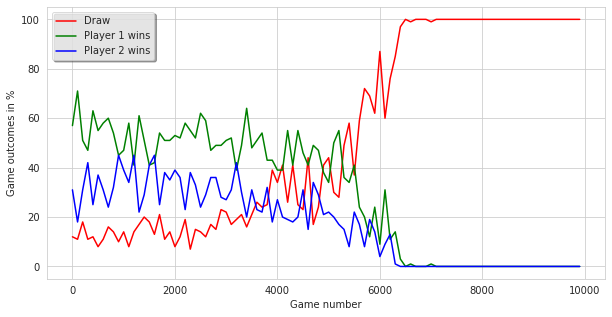

In [239]:
%%time

board = TicTacToe(n_rows=3, n_cols=3, n_win=3)

player_1 = TQPlayer()
player_2 = TQPlayer()

eval_players(board, player_1, player_2, num_battles=100)

### Попробуйте обучить стратегии крестиков и ноликов для доски 4х4 и/или 5х5.

In [240]:
%%time

board = TicTacToe(n_rows=4, n_cols=4, n_win=4)

player_1 = TQPlayer(board_size=4*4) 
player_2 = RandomPlayer() 

reward = play_game(board, player_1, player_2, verbose=True)

-----------------
| x | x | x | x | 
-----------------
| o |   |   |   | 
-----------------
|   |   |   |   | 
-----------------
| o |   |   | o | 
-----------------
CROSS WIN
CPU times: user 24.3 ms, sys: 217 µs, total: 24.5 ms
Wall time: 3.52 s


In [241]:
%%time

board = TicTacToe(n_rows=4, n_cols=4, n_win=4)

player_1 = TQPlayer(board_size=4*4) 
player_2 = RandomPlayer()

_ = battle(board, player_1, player_2, num_games=10000, verbose=True);

After 10000 game we have draws: 1985, Player 1 wins: 5734, and Player 2 wins: 2281.
Which gives percentages of draws: 19.85%, Player 1 wins: 57.34%, and Player 2 wins:  22.81%
CPU times: user 10.8 s, sys: 15.8 ms, total: 10.8 s
Wall time: 10.8 s


CPU times: user 52 s, sys: 107 ms, total: 52.1 s
Wall time: 52.1 s


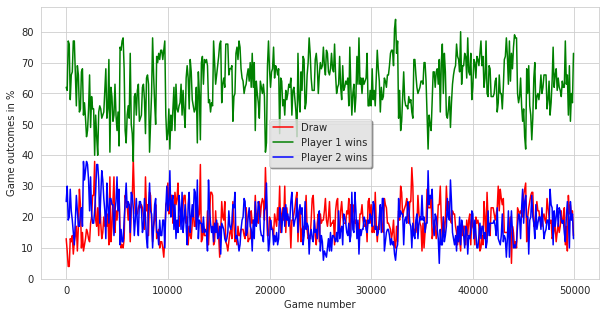

In [243]:
%%time

board = TicTacToe(n_rows=4, n_cols=4, n_win=4)

player_1 = TQPlayer(board_size=4*4) 
player_2 = RandomPlayer()

eval_players(board, player_1, player_2, num_battles=500)

CPU times: user 20min 17s, sys: 2.34 s, total: 20min 20s
Wall time: 20min 19s


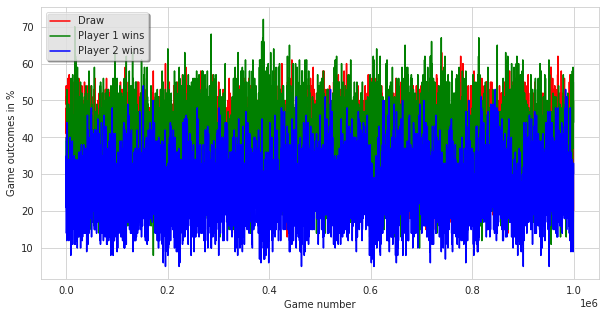

In [247]:
%%time

board = TicTacToe(n_rows=4, n_cols=4, n_win=4)

player_1 = TQPlayer(board_size=4*4) 
player_2 = TQPlayer(board_size=4*4)

eval_players(board, player_1, player_2, num_battles=10000)

## Часть вторая: добавим нейронных сетей

### 3. Реализуйте DQN с нейронной сетью, обучите стратегии крестиков и ноликов.

In [54]:
class TFSN:
    session = None

    @classmethod
    def get_session(cls):
        if TFSN.session is None:
            TFSN.session = tf.Session()
        return TFSN.session

    @classmethod
    def set_session(cls, session):
        if TFSN.session is not None and TFSN.session != session:
            TFSN.session.close()
        TFSN.session = session

In [55]:
class QNetwork:

    def __init__(self, name, learning_rate):
        self.learningRate = learning_rate
        self.name = name
        self.input_positions = None
        self.target_input = None
        self.q_values = None
        self.probabilities = None
        self.train_step = None
        self.build_graph(name)

    def add_dense_layer(self, input_tensor, output_size, activation_fn=None, name=None):
        return tf.layers.dense(input_tensor, output_size, activation=activation_fn,
                               kernel_initializer=tf.contrib.layers.variance_scaling_initializer(),
                               name=name)

    def build_graph(self, name, board_size=3*3):
        with tf.variable_scope(name):
            self.input_positions = tf.placeholder(tf.float32, shape=(None, board_size * 3), name='inputs')
            self.target_input = tf.placeholder(tf.float32, shape=(None, board_size), name='targets')
            
            net = self.input_positions
            net = self.add_dense_layer(net, board_size * 3 * 9, tf.nn.relu)

            self.q_values = self.add_dense_layer(net, board_size, name='q_values')
            self.probabilities = tf.nn.softmax(self.q_values, name='probabilities')
            
            mse = tf.losses.mean_squared_error(predictions=self.q_values, labels=self.target_input)
            self.train_step = tf.train.GradientDescentOptimizer(
                learning_rate=self.learningRate
            ).minimize(mse, name='train')

In [56]:
class NNQPlayer:

    def __init__(self, name, reward_discount=0.95, win_value=1.0, draw_value=0.0,
                 loss_value=-1.0, learning_rate=0.01, training=True, side=1):
        self.reward_discount = reward_discount
        self.win_value = win_value
        self.draw_value = draw_value
        self.loss_value = loss_value
        self.side = None
        self.board_position_log = []
        self.action_log = []
        self.next_max_log = []
        self.values_log = []
        self.name = name
        self.nn = QNetwork(name, learning_rate)
        self.training = training
        self.side = side

    def board_state_to_nn_input(self, state):
        res = np.array([(state == self.side).astype(int),
                        (state == -self.side).astype(int),
                        (state == 0).astype(int)])
        return res.reshape(-1)


    def calculate_targets(self):
        game_length = len(self.action_log)
        targets = []
        for i in range(game_length):
            target = np.copy(self.values_log[i])
            target[self.action_log[i]] = self.reward_discount * self.next_max_log[i]
            targets.append(target)
        return targets

    def get_probs(self, input_pos):
        probs, qvalues = TFSN.get_session().run([self.nn.probabilities, self.nn.q_values],
                                                feed_dict={self.nn.input_positions: [input_pos]})
        return probs[0], qvalues[0]

    def move(self, board):
        
        board_state = board.get_state().copy()
        self.board_position_log.append(board_state)

        nn_input = self.board_state_to_nn_input(board_state)
        probs, qvalues = self.get_probs(nn_input)
        qvalues = np.copy(qvalues)

        for index, p in enumerate(qvalues):
            if not board.is_legal(board.action_from_int(index)):
                probs[index] = -1

        player_action = np.argmax(probs)

        if len(self.action_log) > 0:
            self.next_max_log.append(qvalues[player_action])
            
        self.action_log.append(player_action)
        self.values_log.append(qvalues)

        observation, reward, done, info = board.step(board.action_from_int(player_action))  
        return reward, done

    def final_result(self, final_value):

        self.next_max_log.append(reward)

        if self.training:
            targets = self.calculate_targets()
            nn_input = [self.board_state_to_nn_input(x) for x in self.board_position_log]
            TFSN.get_session().run([self.nn.train_step],
                                   feed_dict={self.nn.input_positions: nn_input, self.nn.target_input: targets})

    def new_game(self):
        self.board_position_log = []
        self.action_log = []
        self.next_max_log = []
        self.values_log = []

In [57]:
def play_game(board, player_1, player_2, verbose=False):
    
    player_1.new_game()
    player_2.new_game()

    board.reset()    
    done = False

    while not done:

        if board.curTurn == 1:
            reward, done = player_1.move(board)
        else:
            reward, done = player_2.move(board)

        if verbose:
            board.printBoard()
            time.sleep(0.5)
            if not done:
                display.clear_output(wait=True)

    if reward == 1:
        reward_str = "CROSS WIN"
        player_1.final_result(1)
        player_2.final_result(0)

    elif reward == -1:
        reward_str = "NAUGHT WIN"
        player_1.final_result(-1)
        player_2.final_result(1)
    else:
        reward_str = 'DRAW'
        player_1.final_result(0)
        player_2.final_result(0.5)

    if verbose:
        print(reward_str)
        
    return reward

In [58]:
def battle(board, player_1, player_2, num_games=100, verbose=False):
      
    draw_count = 0
    cross_count = 0
    naught_count = 0
    
    for _ in range(num_games):
        reward = play_game(board, player_1, player_2)
        if reward == 1:
            cross_count += 1
        elif reward == -1:
            naught_count += 1
        else:
            draw_count += 1

    if verbose:
        print("After {} game we have draws: {}, Player 1 wins: {}, and Player 2 wins: {}.".format(num_games, draw_count,
                                                                                                  cross_count,
                                                                                                  naught_count))

        print("Which gives percentages of draws: {:.2%}, Player 1 wins: {:.2%}, and Player 2 wins:  {:.2%}".format(
            draw_count / num_games, cross_count / num_games, naught_count / num_games))

    return cross_count, naught_count, draw_count

In [59]:
def evaluate_players_v2(board, player_1, player_2, games_per_battle=100, num_battles=100):
    
    player_1_wins = []
    player_2_wins = []
    draws = []
    count = []  
    
    TFSN.set_session(tf.Session())
    TFSN.get_session().run(tf.global_variables_initializer())

    for i in range (num_battles):
        player_1_win, player_2_win, draw = battle(board, player_1, player_2, games_per_battle)
        
        player_1_wins.append(player_1_win * 100.0 / games_per_battle)
        player_2_wins.append(player_2_win * 100.0 / games_per_battle)
        draws.append(draw * 100.0 / games_per_battle)
        
        count.append(i * games_per_battle)
        
    
    plt.figure(figsize=(10,5))

    plt.ylabel('Game outcomes in %')
    plt.xlabel('Game number')

    plt.plot(count, draws, 'r-', label='Draw')
    plt.plot(count, player_1_wins, 'g-', label='Player 1 wins')
    plt.plot(count, player_2_wins, 'b-', label='Player 2 wins')
    
    plt.legend(loc='best', shadow=True, fancybox=True, framealpha =0.7)
    
    TFSN.set_session(None)

CPU times: user 1min 35s, sys: 5.04 s, total: 1min 40s
Wall time: 1min 21s


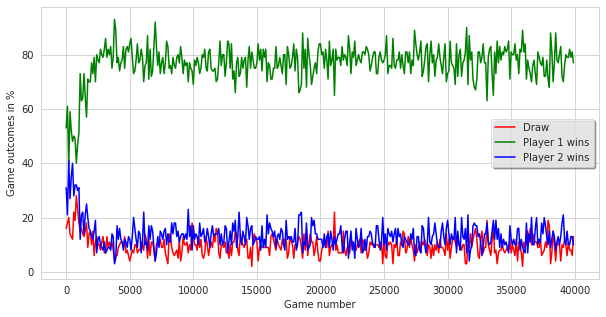

In [19]:
%%time

board = TicTacToe(n_rows=3, n_cols=3, n_win=3)

tf.reset_default_graph()    

player_1 = NNQPlayer("QLearner21")
player_2 = RandomPlayer()

evaluate_players_v2(board, player_1, player_2, num_battles=400)

### 4. Реализуйте Double DQN и/или Dueling DQN.

In [21]:
class QNetwork:
    
    def __init__(self, name, learning_rate):
        self.learningRate = learning_rate
        self.name = name
        self.input_positions = None
        self.target_q = None
        self.actions = None
        self.actions_onehot = None
        self.value = None
        self.advantage = None
        self.td_error = None
        self.q = None
        self.loss = None
        self.q_values = None
        self.probabilities = None
        self.train_step = None
        self.build_graph(name)

    def add_dense_layer(self, input_tensor, output_size, activation_fn=None,
                        name=None):
        return tf.layers.dense(input_tensor, output_size, activation=activation_fn,
                               kernel_initializer=tf.contrib.layers.variance_scaling_initializer(),
                               name=name)

    def build_graph(self, name, board_size=3*3):
        with tf.variable_scope(name):
            self.input_positions = tf.placeholder(tf.float32, shape=(None, board_size * 3), name='inputs')
            self.target_q = tf.placeholder(shape=[None], dtype=tf.float32, name='target')

            net = self.input_positions
            net = self.add_dense_layer(net, board_size * 3 * 9, tf.nn.relu)

            self.value = self.add_dense_layer(net, 1, name='value')
            self.advantage = self.add_dense_layer(net, board_size, name='advantage')

            self.q_values = self.value + tf.subtract(self.advantage,
                                                     tf.reduce_mean(self.advantage, axis=1, keepdims=True))
            self.probabilities = tf.nn.softmax(self.q_values, name='probabilities')

            self.actions = tf.placeholder(shape=[None], dtype=tf.int32, name='actions')
            self.actions_onehot = tf.one_hot(self.actions, board_size, dtype=tf.float32)
            self.q = tf.reduce_sum(tf.multiply(self.q_values, self.actions_onehot), axis=1)

            self.td_error = tf.square(self.target_q - self.q)
            self.loss = tf.reduce_mean(self.td_error)

            self.train_step = tf.train.GradientDescentOptimizer(learning_rate=self.learningRate).minimize(self.loss,
                                                                                                          name='train')

In [23]:
class ReplayBuffer:
    
    def __init__(self, buffer_size=3000):
        self.buffer = []
        self.buffer_size = buffer_size

    def add(self, experience):
        if len(self.buffer) + len(experience) >= self.buffer_size:
            self.buffer[0:1] = []
        self.buffer.append(experience)

    def sample(self, size):
        size = min(len(self.buffer), size)
        return random.sample(self.buffer, size)

In [41]:
class ExpDoubleDuelQPlayer:

    def __init__(self, name, reward_discount=0.95, win_value=1.0, draw_value=0.0,
                 loss_value=-1.0, learning_rate=0.01, training=True, random_move_prob=0.95,
                 random_move_decrease=0.95, batch_size=50, pre_training_games=500, tau=0.001, side=1):
        self.tau = tau
        self.batch_size = batch_size
        self.reward_discount = reward_discount
        self.win_value = win_value
        self.draw_value = draw_value
        self.loss_value = loss_value
        self.side = None
        self.board_position_log = []
        self.action_log = []
        self.next_state_log = []
        self.name = name
        self.q_net = QNetwork(name + '_main', learning_rate)
        self.target_net = QNetwork(name + '_target', learning_rate)
        self.graph_copy_op = self.create_graph_copy_op(name + '_main', name + '_target', self.tau)
        self.training = training
        self.random_move_prob = random_move_prob
        self.random_move_decrease = random_move_decrease
        self.replay_buffer_win = ReplayBuffer()
        self.replay_buffer_loss = ReplayBuffer()
        self.replay_buffer_draw = ReplayBuffer()
        self.game_counter = 0
        self.pre_training_games = pre_training_games
        self.side = side

    def add_game_to_replay_buffer(self, reward):
        game_length = len(self.action_log)
        if reward == self.win_value:
            buffer = self.replay_buffer_win
        elif reward == self.loss_value:
            buffer = self.replay_buffer_loss
        else:
            buffer = self.replay_buffer_draw
        for i in range(game_length - 1):
            buffer.add([self.board_position_log[i], self.action_log[i],
                        self.board_position_log[i + 1], 0])
        buffer.add([self.board_position_log[game_length - 1], self.action_log[game_length - 1], None, reward])

    def get_probs(self, input_pos, network):
        probs, qvalues = TFSN.get_session().run([network.probabilities, network.q_values],
                                                feed_dict={network.input_positions: input_pos})
        return probs, qvalues

    def get_valid_probs(self, input_pos, network, boards):
        probabilities, qvals = self.get_probs(input_pos, network)
        qvals = np.copy(qvals)
        probabilities = np.copy(probabilities)
        for q, prob, b in zip(qvals, probabilities, boards):
            for index, p in enumerate(q):
                if not b.is_legal(b.action_from_int(index)):
                    prob[index] = -1
                elif prob[index] < 0:
                    prob[index] = 0.0
        return probabilities, qvals

    def move(self, board):
    
    
        board_state = board.get_state().copy()
        self.board_position_log.append(board_state)

        nn_input = self.board_state_to_nn_input(board_state)
        probs, _ = self.get_valid_probs([nn_input], self.q_net, [board])
        probs = probs[0]
        
        if (self.training is True) and \
                ((self.game_counter < self.pre_training_games) or (np.random.rand(1) < self.random_move_prob)):
            empy_spaces = board.getEmptySpaces()
            player_action = board.int_from_action(empy_spaces[np.random.randint(len(empy_spaces))])
        else:
            player_action = np.argmax(probs)
        
        self.action_log.append(player_action)
        
        observation, reward, done, info = board.step(board.action_from_int(player_action))  
        return reward, done
    
    
    def final_result(self, reward):
   
   
        self.add_game_to_replay_buffer(reward)

        # If we are in training mode we run the optimizer.
        if self.training and (self.game_counter > self.pre_training_games):

            batch_third = self.batch_size // 3
            train_batch = self.replay_buffer_win.sample(batch_third)
            train_batch.extend(self.replay_buffer_loss.sample(batch_third))
            train_batch.extend(self.replay_buffer_draw.sample(batch_third))
            train_batch = np.array(train_batch)

            #
            # Let's compute the target q values for all non terminal move
            # We extract the resulting state, run it through the target net work and
            # get the maximum q value (of all valid moves)
            next_states = [s[2] for s in train_batch if s[2] is not None]
            target_qs = []

            if len(next_states) > 0:
                probs, qvals = self.get_valid_probs([self.board_state_to_nn_input(s) for s in next_states],
                                                    self.target_net, [Board(s) for s in next_states])

                i = 0
                for t in train_batch:
                    if t[2] is not None:
                        max_move = np.argmax(probs[i])
                        max_qval = qvals[i][max_move]
                        target_qs.append(max_qval * self.reward_discount)
                        i += 1
                    else:
                        target_qs.append(t[3])

                if i != len(next_states):
                    print("Something wrong here!!!")
            else:
                target_qs.extend(train_batch[:, 3])

            # We convert the input states we have recorded to feature vectors to feed into the training.
            nn_input = [self.board_state_to_nn_input(x[0]) for x in train_batch]
            actions = train_batch[:, 1]
            # We run the training step with the recorded inputs and new Q value targets.
            TFSN.get_session().run([self.q_net.train_step],
                                   feed_dict={self.q_net.input_positions: nn_input,
                                              self.q_net.target_q: target_qs,
                                              self.q_net.actions: actions})

            TFSN.get_session().run(self.graph_copy_op)

            self.random_move_prob *= self.random_move_decrease

    def board_state_to_nn_input(self, state):
        res = np.array([(state == self.side).astype(int),
                        (state == -self.side).astype(int),
                        (state == 0).astype(int)])
        return res.reshape(-1)
    
    def create_graph_copy_op(self, src: str, target: str, tau: float) -> [tf.Tensor]:
        src_vars = tf.trainable_variables(src)
        target_vars = tf.trainable_variables(target)
        op_holder = []
        for s, t in zip(src_vars, target_vars):
            op_holder.append(t.assign((s.value() * tau) + ((1 - tau) * t.value())))
        return op_holder

    def new_game(self):
        self.board_position_log = []
        self.action_log = []

CPU times: user 1min 16s, sys: 2.96 s, total: 1min 18s
Wall time: 1min 7s


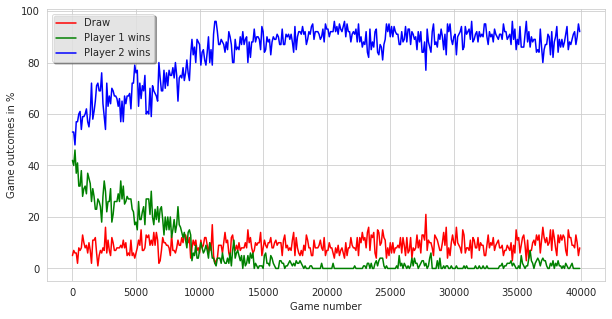

In [49]:
%%time

board = TicTacToe(n_rows=3, n_cols=3, n_win=3)

tf.reset_default_graph()

player_1 = ExpDoubleDuelQPlayer("QLearners1162")
player_2 = RandomPlayer() 

evaluate_players_v2(board, player_1, player_2, num_battles=400)